## import libraries

In [1]:
!pip3 install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.9 MB/s eta 0:00:00


In [2]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load images

In [5]:
#Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
def load_images_A(path,file, size=(64, 64), max_images=None):
    data_list = []
    for i in range(2603):
            if (file.at[i, 'Eyeglasses'] == 1 and file.at[i, 'Male'] == 1):
                pixels = load_img(path +file.at[i,'image_id'], target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)
def load_images_B(path,file, size=(64, 64), max_images=None):
    data_list = []
    for i in range(2603):
            if (file.at[i, 'Eyeglasses'] == -1 and file.at[i, 'Male'] == 1):
                pixels = load_img(path + file.at[i,'image_id'], target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)
celeb_path = '/content/drive/MyDrive/img1/'
ab=pd.read_csv('/content/list_attr_celeba.csv')

dataA = load_images_A(celeb_path,ab, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images_B(celeb_path,ab,  max_images=1000)
print('loaded dataB', dataB.shape)

filename = 'celeb.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


loaded dataA (123, 64, 64, 3)
loaded dataB (965, 64, 64, 3)
Saved dataset: celeb.npz


In [ ]:
#Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
def load_images_A(path,file, size=(64, 64), max_images=None):
    data_list = []
    for i in range(2603):
            if (file.at[i, 'Eyeglasses'] == 1 and file.at[i, 'Male'] == 1):
                pixels = load_img(path +file.at[i,'image_id'], target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)
def load_images_B(path,file, size=(64, 64), max_images=None):
    data_list = []
    for i in range(2603):
            if (file.at[i, 'Eyeglasses'] == -1 and file.at[i, 'Male'] == -1):
                pixels = load_img(path + file.at[i,'image_id'], target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)
celeb_path = '/content/drive/MyDrive/img1/'
ab=pd.read_csv('/content/list_attr_celeba.csv')

dataA = load_images_A(celeb_path,ab, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images_B(celeb_path,ab,  max_images=1000)
print('loaded dataB', dataB.shape)

filename = 'celeb.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


## Plotting images of Celebrity and Cartoon

Loaded data: (123, 64, 64, 3) (965, 64, 64, 3)


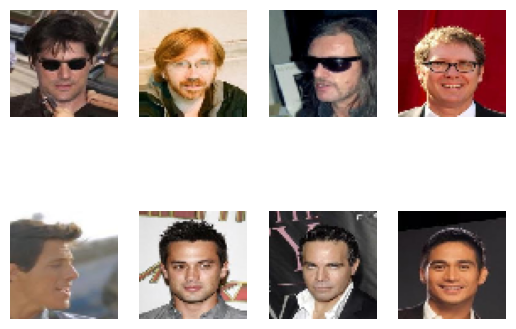

In [6]:
from numpy import load
data = load('/content/celeb.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


In [7]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(512,(4,4) , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)

    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model

image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization (In  (None, 16, 16, 128)       256       
 stanceNormalization)                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

## Defining generator model

The generator is an encoder- decoder model, where model takes source image (e.g. celebrity photo) and generates a target image (e.g. cartoon photo) by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections by series of layers that upsample or decode the representation to the size of output image.

So Defining the ResNet block having two 3 X 3 filters and 1 X 1 stride where input to block is concatenated to output of block channel wise.

In [8]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    #print(layer.shape)  # print the shape of the previous layer

    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)

    # skip connection
    x = Concatenate()([x, layer])
    return x


In [9]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU()(x)
    return x

In [10]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64
    x = Conv2D(64,(7,7) , padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128
    x = Conv2D(128,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256
    x = Conv2D(256,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)

    for i in range(n_resnet):
        x = resnet_block(256 , x)

    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model
image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 instance_normalization_4 (  (None, 64, 64, 64)           128       ['conv2d_6[0][0]']            
 InstanceNormalization)                                                                           
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['instance_normalization

## Defining Composite model

In [11]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False

    # Input for generated images
    input_gen = Input(shape=image_shape)

    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)

    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)

    # Input for identity mapping
    input_id = Input(shape=image_shape)

    # Forward pass for identity mapping
    output_id = g_model_1(input_id)

    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)

    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)

    return model

## Load real samples

In [12]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

In [13]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


In [14]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)

    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))

    return X, y


In [15]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop



In [16]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [24]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('/content/celeb.npz')
        celeb, cartoon = dataA[id], dataB[id]
        celeb_pred, cartoon_pred = g_BA.predict(tf.expand_dims(cartoon, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]

        plt.figure(figsize=(10, 8))

        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Org Man w/ glasses')

        plt.subplot(1, 4, 2)
        show_image(cartoon_pred, title='Gen Man w/ glasses')

        plt.subplot(1, 4, 3)
        show_image(cartoon.astype('uint8'), title='Org Man w/o glasses')

        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Gen man w/o glasses')


        plt.show()

## Train cyclegan model

In [18]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=2, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch
    #manually enumerate epochs
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)

            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)





            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))

        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)



Loaded (123, 64, 64, 3) (965, 64, 64, 3)


Batchs:   0%|          | 0/123 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   1%|          | 1/123 [01:44<3:33:15, 104.88s/it]

>1, dA[0.957 ,0.722 ] dB[0.632 ,0.635] g[18.593 ,20.170]
1/1 [==============================] - 0s 326ms/step



Batchs:   2%|▏         | 2/123 [02:02<1:48:00, 53.56s/it] 

>2, dA[2.625 ,0.846 ] dB[0.751 ,0.697] g[18.703 ,18.946]
1/1 [==============================] - 1s 589ms/step



Batchs:   2%|▏         | 3/123 [02:15<1:09:52, 34.93s/it]

>3, dA[0.683 ,0.310 ] dB[0.616 ,0.899] g[20.510 ,20.395]
1/1 [==============================] - 0s 330ms/step



Batchs:   3%|▎         | 4/123 [02:28<52:07, 26.28s/it]  

>4, dA[0.793 ,0.252 ] dB[0.555 ,0.740] g[16.959 ,17.978]
1/1 [==============================] - 0s 320ms/step



Batchs:   4%|▍         | 5/123 [02:40<41:48, 21.26s/it]

>5, dA[0.612 ,0.517 ] dB[1.068 ,1.590] g[19.890 ,19.241]
1/1 [==============================] - 0s 318ms/step



Batchs:   5%|▍         | 6/123 [02:56<38:06, 19.55s/it]

>6, dA[2.241 ,0.538 ] dB[0.801 ,0.930] g[19.183 ,19.075]
1/1 [==============================] - 0s 325ms/step



Batchs:   6%|▌         | 7/123 [03:09<33:17, 17.22s/it]

>7, dA[2.438 ,0.726 ] dB[4.287 ,1.614] g[19.259 ,17.283]
1/1 [==============================] - 0s 346ms/step



Batchs:   7%|▋         | 8/123 [03:26<32:44, 17.08s/it]

>8, dA[1.163 ,0.480 ] dB[3.039 ,1.267] g[22.206 ,21.510]
1/1 [==============================] - 0s 337ms/step



Batchs:   7%|▋         | 9/123 [03:38<29:43, 15.64s/it]

>9, dA[1.297 ,0.418 ] dB[2.102 ,0.548] g[19.808 ,19.669]
1/1 [==============================] - 0s 336ms/step



Batchs:   8%|▊         | 10/123 [03:52<28:16, 15.01s/it]

>10, dA[1.583 ,1.657 ] dB[1.350 ,0.539] g[18.139 ,20.048]
1/1 [==============================] - 1s 615ms/step



Batchs:   9%|▉         | 11/123 [04:05<26:48, 14.36s/it]

>11, dA[1.154 ,1.696 ] dB[2.314 ,0.945] g[20.647 ,22.482]
1/1 [==============================] - 0s 495ms/step



Batchs:  10%|▉         | 12/123 [04:17<25:16, 13.67s/it]

>12, dA[2.244 ,1.215 ] dB[1.111 ,0.677] g[20.231 ,21.261]
1/1 [==============================] - 1s 583ms/step



Batchs:  11%|█         | 13/123 [04:29<24:15, 13.23s/it]

>13, dA[2.309 ,0.727 ] dB[1.732 ,5.172] g[24.780 ,21.311]
1/1 [==============================] - 0s 386ms/step



Batchs:  11%|█▏        | 14/123 [04:42<23:45, 13.08s/it]

>14, dA[1.244 ,1.274 ] dB[1.252 ,1.271] g[17.829 ,19.610]
1/1 [==============================] - 0s 318ms/step



Batchs:  12%|█▏        | 15/123 [04:54<23:13, 12.90s/it]

>15, dA[3.588 ,0.570 ] dB[4.025 ,2.216] g[20.154 ,18.189]
1/1 [==============================] - 0s 330ms/step



Batchs:  13%|█▎        | 16/123 [05:07<22:59, 12.90s/it]

>16, dA[1.831 ,5.387 ] dB[1.787 ,2.209] g[20.177 ,29.670]
1/1 [==============================] - 0s 319ms/step



Batchs:  14%|█▍        | 17/123 [05:23<24:36, 13.93s/it]

>17, dA[1.806 ,2.499 ] dB[7.514 ,1.507] g[16.915 ,19.777]
1/1 [==============================] - 0s 326ms/step



Batchs:  15%|█▍        | 18/123 [05:36<23:37, 13.50s/it]

>18, dA[0.840 ,5.353 ] dB[3.410 ,1.909] g[22.003 ,21.086]
1/1 [==============================] - 0s 335ms/step



Batchs:  15%|█▌        | 19/123 [05:48<22:47, 13.15s/it]

>19, dA[0.894 ,1.671 ] dB[1.070 ,0.601] g[17.852 ,19.522]
1/1 [==============================] - 0s 349ms/step



Batchs:  16%|█▋        | 20/123 [06:02<22:43, 13.24s/it]

>20, dA[2.094 ,1.252 ] dB[0.528 ,1.533] g[20.158 ,19.694]
1/1 [==============================] - 1s 643ms/step



Batchs:  17%|█▋        | 21/123 [06:14<22:10, 13.05s/it]

>21, dA[1.417 ,1.657 ] dB[0.801 ,0.798] g[17.833 ,17.750]
1/1 [==============================] - 0s 323ms/step



Batchs:  18%|█▊        | 22/123 [06:27<21:48, 12.95s/it]

>22, dA[1.771 ,1.381 ] dB[1.368 ,1.680] g[20.442 ,20.607]
1/1 [==============================] - 0s 322ms/step



Batchs:  19%|█▊        | 23/123 [06:39<21:19, 12.80s/it]

>23, dA[1.521 ,4.883 ] dB[1.273 ,0.872] g[20.401 ,26.820]
1/1 [==============================] - 0s 326ms/step



Batchs:  20%|█▉        | 24/123 [06:56<22:58, 13.92s/it]

>24, dA[0.463 ,1.547 ] dB[1.593 ,1.448] g[16.893 ,18.292]
1/1 [==============================] - 0s 323ms/step



Batchs:  20%|██        | 25/123 [07:13<24:29, 15.00s/it]

>25, dA[1.852 ,2.040 ] dB[1.006 ,0.530] g[18.281 ,19.573]
1/1 [==============================] - 1s 591ms/step



Batchs:  21%|██        | 26/123 [07:32<25:50, 15.99s/it]

>26, dA[8.608 ,1.762 ] dB[1.394 ,4.647] g[25.996 ,17.967]
1/1 [==============================] - 1s 619ms/step



Batchs:  22%|██▏       | 27/123 [07:51<27:00, 16.88s/it]

>27, dA[1.922 ,3.862 ] dB[1.229 ,1.424] g[19.194 ,23.730]
1/1 [==============================] - 0s 334ms/step



Batchs:  23%|██▎       | 28/123 [08:03<24:38, 15.57s/it]

>28, dA[2.773 ,1.750 ] dB[1.181 ,3.735] g[23.727 ,20.736]
1/1 [==============================] - 0s 345ms/step



Batchs:  24%|██▎       | 29/123 [08:20<24:53, 15.88s/it]

>29, dA[1.501 ,2.358 ] dB[1.079 ,1.527] g[20.019 ,18.216]
1/1 [==============================] - 0s 327ms/step



Batchs:  24%|██▍       | 30/123 [08:36<24:47, 15.99s/it]

>30, dA[1.482 ,2.909 ] dB[0.602 ,1.955] g[20.714 ,21.507]
1/1 [==============================] - 0s 324ms/step



Batchs:  25%|██▌       | 31/123 [08:49<23:06, 15.07s/it]

>31, dA[3.060 ,1.654 ] dB[1.677 ,0.886] g[16.881 ,20.742]
1/1 [==============================] - 0s 321ms/step



Batchs:  26%|██▌       | 32/123 [09:01<21:42, 14.31s/it]

>32, dA[0.872 ,0.782 ] dB[0.365 ,0.761] g[14.788 ,16.099]
1/1 [==============================] - 0s 320ms/step



Batchs:  27%|██▋       | 33/123 [09:18<22:19, 14.88s/it]

>33, dA[6.177 ,2.596 ] dB[1.342 ,5.963] g[26.823 ,18.562]
1/1 [==============================] - 0s 333ms/step



Batchs:  28%|██▊       | 34/123 [09:34<22:39, 15.28s/it]

>34, dA[1.024 ,2.607 ] dB[3.131 ,0.491] g[16.493 ,19.710]
1/1 [==============================] - 0s 326ms/step



Batchs:  28%|██▊       | 35/123 [09:51<23:01, 15.70s/it]

>35, dA[1.079 ,1.076 ] dB[0.995 ,1.975] g[18.294 ,14.701]
1/1 [==============================] - 0s 319ms/step



Batchs:  29%|██▉       | 36/123 [10:08<23:23, 16.13s/it]

>36, dA[1.474 ,0.788 ] dB[0.902 ,1.660] g[17.218 ,14.070]
1/1 [==============================] - 0s 330ms/step



Batchs:  30%|███       | 37/123 [10:26<24:10, 16.86s/it]

>37, dA[0.923 ,0.990 ] dB[0.651 ,2.003] g[16.486 ,16.571]
1/1 [==============================] - 1s 559ms/step



Batchs:  31%|███       | 38/123 [10:43<23:51, 16.84s/it]

>38, dA[0.398 ,0.462 ] dB[0.624 ,0.848] g[16.661 ,18.453]
1/1 [==============================] - 0s 350ms/step



Batchs:  32%|███▏      | 39/123 [10:59<23:20, 16.67s/it]

>39, dA[4.643 ,0.738 ] dB[0.999 ,2.457] g[17.497 ,15.006]
1/1 [==============================] - 0s 334ms/step



Batchs:  33%|███▎      | 40/123 [11:16<22:54, 16.56s/it]

>40, dA[0.561 ,0.850 ] dB[0.918 ,0.586] g[12.951 ,14.136]
1/1 [==============================] - 0s 319ms/step



Batchs:  33%|███▎      | 41/123 [11:33<22:47, 16.67s/it]

>41, dA[0.774 ,1.142 ] dB[0.453 ,0.418] g[11.679 ,14.207]
1/1 [==============================] - 0s 337ms/step



Batchs:  34%|███▍      | 42/123 [11:45<20:56, 15.52s/it]

>42, dA[0.483 ,0.559 ] dB[0.950 ,1.014] g[16.023 ,16.161]
1/1 [==============================] - 0s 317ms/step



Batchs:  35%|███▍      | 43/123 [11:58<19:27, 14.59s/it]

>43, dA[0.654 ,0.309 ] dB[0.946 ,0.577] g[14.751 ,13.244]
1/1 [==============================] - 0s 321ms/step



Batchs:  36%|███▌      | 44/123 [12:14<19:52, 15.09s/it]

>44, dA[2.023 ,0.351 ] dB[0.931 ,0.634] g[13.247 ,12.966]
1/1 [==============================] - 0s 322ms/step



Batchs:  37%|███▋      | 45/123 [12:29<19:27, 14.97s/it]

>45, dA[0.779 ,0.513 ] dB[0.589 ,0.563] g[10.783 ,11.463]
1/1 [==============================] - 0s 339ms/step



Batchs:  37%|███▋      | 46/123 [12:45<19:44, 15.38s/it]

>46, dA[0.758 ,0.251 ] dB[0.218 ,0.481] g[11.619 ,12.395]
1/1 [==============================] - 0s 324ms/step



Batchs:  38%|███▊      | 47/123 [13:02<19:59, 15.79s/it]

>47, dA[0.223 ,0.661 ] dB[0.770 ,0.629] g[12.681 ,13.553]
1/1 [==============================] - 0s 320ms/step



Batchs:  39%|███▉      | 48/123 [13:14<18:31, 14.82s/it]

>48, dA[0.768 ,0.514 ] dB[0.372 ,0.197] g[11.889 ,12.051]
1/1 [==============================] - 0s 319ms/step



Batchs:  40%|███▉      | 49/123 [13:27<17:33, 14.23s/it]

>49, dA[0.851 ,0.325 ] dB[0.262 ,0.939] g[16.727 ,16.292]
1/1 [==============================] - 0s 347ms/step



Batchs:  41%|████      | 50/123 [13:40<16:41, 13.71s/it]

>50, dA[0.204 ,0.784 ] dB[0.391 ,0.535] g[12.529 ,13.796]
1/1 [==============================] - 0s 333ms/step



Batchs:  41%|████▏     | 51/123 [13:51<15:39, 13.05s/it]

>51, dA[0.451 ,1.047 ] dB[0.241 ,0.681] g[14.315 ,14.587]
1/1 [==============================] - 1s 561ms/step



Batchs:  42%|████▏     | 52/123 [14:03<15:04, 12.75s/it]

>52, dA[3.389 ,0.917 ] dB[0.516 ,0.673] g[11.921 ,12.536]
1/1 [==============================] - 1s 534ms/step



Batchs:  43%|████▎     | 53/123 [14:16<14:55, 12.79s/it]

>53, dA[0.699 ,0.861 ] dB[0.380 ,0.950] g[12.029 ,12.883]
1/1 [==============================] - 0s 325ms/step



Batchs:  44%|████▍     | 54/123 [14:29<14:48, 12.87s/it]

>54, dA[0.815 ,2.124 ] dB[0.905 ,3.486] g[14.527 ,17.177]
1/1 [==============================] - 0s 329ms/step



Batchs:  45%|████▍     | 55/123 [14:44<15:05, 13.32s/it]

>55, dA[1.002 ,1.733 ] dB[0.395 ,0.402] g[12.260 ,12.178]
1/1 [==============================] - 0s 329ms/step



Batchs:  46%|████▌     | 56/123 [15:00<15:50, 14.18s/it]

>56, dA[0.924 ,4.087 ] dB[0.463 ,0.435] g[10.527 ,10.357]
1/1 [==============================] - 0s 328ms/step



Batchs:  46%|████▋     | 57/123 [15:16<16:22, 14.88s/it]

>57, dA[0.546 ,1.463 ] dB[1.222 ,2.661] g[14.218 ,14.153]
1/1 [==============================] - 0s 338ms/step



Batchs:  47%|████▋     | 58/123 [15:34<16:58, 15.67s/it]

>58, dA[2.098 ,0.956 ] dB[0.559 ,0.375] g[12.750 ,11.347]
1/1 [==============================] - 0s 422ms/step



Batchs:  48%|████▊     | 59/123 [15:47<15:47, 14.81s/it]

>59, dA[0.424 ,1.218 ] dB[1.277 ,0.499] g[10.775 ,11.868]
1/1 [==============================] - 0s 343ms/step



Batchs:  49%|████▉     | 60/123 [15:59<14:50, 14.14s/it]

>60, dA[0.432 ,1.203 ] dB[0.831 ,0.296] g[10.569 ,11.706]
1/1 [==============================] - 0s 334ms/step



Batchs:  50%|████▉     | 61/123 [16:16<15:27, 14.96s/it]

>61, dA[0.367 ,1.094 ] dB[0.419 ,1.531] g[11.931 ,9.310]
1/1 [==============================] - 0s 319ms/step



Batchs:  50%|█████     | 62/123 [16:29<14:33, 14.31s/it]

>62, dA[0.459 ,0.413 ] dB[0.208 ,0.632] g[12.958 ,13.074]
1/1 [==============================] - 0s 320ms/step



Batchs:  51%|█████     | 63/123 [16:46<15:08, 15.14s/it]

>63, dA[0.392 ,0.411 ] dB[1.117 ,0.691] g[12.429 ,12.658]
1/1 [==============================] - 0s 331ms/step



Batchs:  52%|█████▏    | 64/123 [16:59<14:07, 14.36s/it]

>64, dA[0.965 ,0.711 ] dB[0.567 ,0.929] g[12.092 ,12.706]
1/1 [==============================] - 0s 334ms/step



Batchs:  53%|█████▎    | 65/123 [17:16<14:41, 15.20s/it]

>65, dA[0.549 ,0.274 ] dB[0.360 ,0.414] g[10.863 ,9.537]
1/1 [==============================] - 0s 407ms/step



Batchs:  54%|█████▎    | 66/123 [17:29<13:47, 14.52s/it]

>66, dA[0.530 ,1.786 ] dB[0.268 ,0.127] g[8.623 ,10.048]
1/1 [==============================] - 0s 319ms/step



Batchs:  54%|█████▍    | 67/123 [17:45<14:12, 15.22s/it]

>67, dA[0.501 ,0.342 ] dB[1.458 ,2.178] g[12.916 ,10.482]
1/1 [==============================] - 0s 315ms/step



Batchs:  55%|█████▌    | 68/123 [17:58<13:09, 14.35s/it]

>68, dA[0.221 ,0.307 ] dB[0.568 ,1.917] g[13.077 ,12.712]
1/1 [==============================] - 0s 318ms/step



Batchs:  56%|█████▌    | 69/123 [18:15<13:43, 15.25s/it]

>69, dA[0.856 ,0.282 ] dB[0.547 ,0.808] g[15.018 ,14.258]
1/1 [==============================] - 0s 341ms/step



Batchs:  57%|█████▋    | 70/123 [18:28<12:44, 14.43s/it]

>70, dA[0.259 ,1.542 ] dB[1.055 ,1.341] g[8.755 ,9.262]
1/1 [==============================] - 0s 332ms/step



Batchs:  58%|█████▊    | 71/123 [18:40<12:01, 13.88s/it]

>71, dA[0.121 ,0.171 ] dB[0.246 ,0.729] g[10.887 ,11.405]
1/1 [==============================] - 0s 345ms/step



Batchs:  59%|█████▊    | 72/123 [18:54<11:39, 13.71s/it]

>72, dA[0.187 ,0.422 ] dB[0.416 ,0.940] g[12.852 ,12.543]
1/1 [==============================] - 1s 564ms/step



Batchs:  59%|█████▉    | 73/123 [19:07<11:23, 13.66s/it]

>73, dA[0.207 ,0.215 ] dB[0.185 ,1.441] g[12.217 ,12.131]
1/1 [==============================] - 0s 324ms/step



Batchs:  60%|██████    | 74/123 [19:19<10:37, 13.02s/it]

>74, dA[0.593 ,0.166 ] dB[0.510 ,0.511] g[10.487 ,10.097]
1/1 [==============================] - 1s 606ms/step



Batchs:  61%|██████    | 75/123 [19:31<10:13, 12.79s/it]

>75, dA[0.257 ,1.734 ] dB[0.410 ,0.516] g[10.566 ,11.428]
1/1 [==============================] - 0s 318ms/step



Batchs:  62%|██████▏   | 76/123 [19:44<09:59, 12.74s/it]

>76, dA[0.367 ,1.281 ] dB[0.098 ,3.009] g[8.968 ,8.453]
1/1 [==============================] - 0s 318ms/step



Batchs:  63%|██████▎   | 77/123 [19:56<09:49, 12.82s/it]

>77, dA[0.142 ,1.364 ] dB[0.234 ,1.092] g[9.735 ,11.098]
1/1 [==============================] - 0s 321ms/step



Batchs:  63%|██████▎   | 78/123 [20:13<10:28, 13.96s/it]

>78, dA[0.214 ,0.397 ] dB[0.255 ,0.144] g[10.841 ,11.196]
1/1 [==============================] - 0s 331ms/step



Batchs:  64%|██████▍   | 79/123 [20:31<11:01, 15.04s/it]

>79, dA[0.493 ,0.474 ] dB[0.137 ,0.226] g[12.639 ,13.427]
1/1 [==============================] - 0s 465ms/step



Batchs:  65%|██████▌   | 80/123 [20:44<10:18, 14.39s/it]

>80, dA[0.222 ,0.572 ] dB[0.530 ,0.474] g[9.036 ,9.913]
1/1 [==============================] - 0s 337ms/step



Batchs:  66%|██████▌   | 81/123 [20:56<09:45, 13.93s/it]

>81, dA[0.651 ,0.350 ] dB[0.292 ,0.928] g[12.997 ,11.128]
1/1 [==============================] - 0s 339ms/step



Batchs:  67%|██████▋   | 82/123 [21:11<09:37, 14.08s/it]

>82, dA[0.407 ,0.340 ] dB[0.345 ,0.429] g[11.942 ,11.188]
1/1 [==============================] - 0s 319ms/step



Batchs:  67%|██████▋   | 83/123 [21:23<09:05, 13.64s/it]

>83, dA[0.571 ,2.541 ] dB[0.191 ,0.391] g[10.720 ,11.175]
1/1 [==============================] - 0s 320ms/step



Batchs:  68%|██████▊   | 84/123 [21:40<09:22, 14.44s/it]

>84, dA[0.218 ,0.204 ] dB[0.543 ,0.277] g[10.146 ,9.926]
1/1 [==============================] - 0s 326ms/step



Batchs:  69%|██████▉   | 85/123 [21:56<09:29, 15.00s/it]

>85, dA[0.451 ,0.273 ] dB[0.261 ,0.202] g[12.739 ,12.438]
1/1 [==============================] - 0s 336ms/step



Batchs:  70%|██████▉   | 86/123 [22:09<08:48, 14.29s/it]

>86, dA[0.141 ,0.417 ] dB[0.084 ,0.322] g[11.748 ,13.336]
1/1 [==============================] - 0s 337ms/step



Batchs:  71%|███████   | 87/123 [22:25<08:56, 14.90s/it]

>87, dA[0.344 ,0.382 ] dB[0.204 ,0.206] g[8.783 ,9.422]
1/1 [==============================] - 0s 334ms/step



Batchs:  72%|███████▏  | 88/123 [22:38<08:18, 14.25s/it]

>88, dA[0.115 ,0.208 ] dB[0.252 ,0.138] g[13.976 ,12.733]
1/1 [==============================] - 0s 330ms/step



Batchs:  72%|███████▏  | 89/123 [22:54<08:29, 14.99s/it]

>89, dA[0.256 ,0.290 ] dB[0.347 ,0.323] g[10.573 ,12.118]
1/1 [==============================] - 0s 318ms/step



Batchs:  73%|███████▎  | 90/123 [23:11<08:28, 15.42s/it]

>90, dA[0.452 ,0.399 ] dB[0.219 ,0.425] g[10.623 ,11.517]
1/1 [==============================] - 0s 320ms/step



Batchs:  74%|███████▍  | 91/123 [23:23<07:45, 14.54s/it]

>91, dA[0.050 ,0.377 ] dB[0.184 ,0.204] g[8.781 ,9.554]
1/1 [==============================] - 0s 316ms/step



Batchs:  75%|███████▍  | 92/123 [23:40<07:49, 15.13s/it]

>92, dA[0.218 ,0.251 ] dB[0.118 ,0.613] g[10.391 ,11.537]
1/1 [==============================] - 0s 321ms/step



Batchs:  76%|███████▌  | 93/123 [23:57<07:52, 15.75s/it]

>93, dA[0.136 ,0.258 ] dB[0.120 ,0.610] g[9.816 ,9.726]
1/1 [==============================] - 0s 323ms/step



Batchs:  76%|███████▋  | 94/123 [24:10<07:08, 14.79s/it]

>94, dA[0.173 ,0.083 ] dB[0.135 ,0.130] g[8.866 ,9.637]
1/1 [==============================] - 0s 320ms/step



Batchs:  77%|███████▋  | 95/123 [24:27<07:16, 15.58s/it]

>95, dA[0.602 ,0.234 ] dB[0.115 ,0.199] g[9.867 ,10.201]
1/1 [==============================] - 0s 323ms/step



Batchs:  78%|███████▊  | 96/123 [24:45<07:21, 16.34s/it]

>96, dA[0.326 ,0.333 ] dB[0.087 ,0.199] g[11.007 ,11.025]
1/1 [==============================] - 0s 335ms/step



Batchs:  79%|███████▉  | 97/123 [24:56<06:24, 14.80s/it]

>97, dA[0.551 ,0.278 ] dB[0.178 ,0.303] g[8.389 ,9.229]
1/1 [==============================] - 1s 607ms/step



Batchs:  80%|███████▉  | 98/123 [25:09<05:52, 14.09s/it]

>98, dA[0.600 ,0.129 ] dB[0.242 ,0.415] g[11.500 ,10.518]
1/1 [==============================] - 0s 321ms/step



Batchs:  80%|████████  | 99/123 [25:27<06:07, 15.31s/it]

>99, dA[0.203 ,0.211 ] dB[0.249 ,0.053] g[9.777 ,10.618]
1/1 [==============================] - 0s 330ms/step



Batchs:  81%|████████▏ | 100/123 [25:44<06:02, 15.78s/it]

>100, dA[0.373 ,0.194 ] dB[0.217 ,0.573] g[9.597 ,10.448]
1/1 [==============================] - 0s 331ms/step



Batchs:  82%|████████▏ | 101/123 [26:00<05:50, 15.92s/it]

>101, dA[0.109 ,0.484 ] dB[0.187 ,0.071] g[13.448 ,11.993]
1/1 [==============================] - 0s 325ms/step



Batchs:  83%|████████▎ | 102/123 [26:17<05:38, 16.14s/it]

>102, dA[0.282 ,0.149 ] dB[0.203 ,0.110] g[9.052 ,10.516]
1/1 [==============================] - 0s 317ms/step



Batchs:  84%|████████▎ | 103/123 [26:35<05:33, 16.69s/it]

>103, dA[0.246 ,0.215 ] dB[0.140 ,0.136] g[12.050 ,11.928]
1/1 [==============================] - 1s 609ms/step



Batchs:  85%|████████▍ | 104/123 [26:47<04:54, 15.50s/it]

>104, dA[0.032 ,0.186 ] dB[0.468 ,0.038] g[10.787 ,10.818]
1/1 [==============================] - 0s 331ms/step



Batchs:  85%|████████▌ | 105/123 [27:00<04:24, 14.69s/it]

>105, dA[0.146 ,0.229 ] dB[0.107 ,0.232] g[9.564 ,9.364]
1/1 [==============================] - 0s 336ms/step



Batchs:  86%|████████▌ | 106/123 [27:13<03:59, 14.06s/it]

>106, dA[0.212 ,0.248 ] dB[0.390 ,0.328] g[9.876 ,9.879]
1/1 [==============================] - 0s 338ms/step



Batchs:  87%|████████▋ | 107/123 [27:26<03:39, 13.70s/it]

>107, dA[0.173 ,0.340 ] dB[0.128 ,2.010] g[8.698 ,8.473]
1/1 [==============================] - 0s 324ms/step



Batchs:  88%|████████▊ | 108/123 [27:42<03:37, 14.50s/it]

>108, dA[0.291 ,0.380 ] dB[0.323 ,1.444] g[8.825 ,8.594]
1/1 [==============================] - 0s 349ms/step



Batchs:  89%|████████▊ | 109/123 [27:59<03:31, 15.13s/it]

>109, dA[0.576 ,0.162 ] dB[0.321 ,0.467] g[8.984 ,9.675]
1/1 [==============================] - 0s 331ms/step



Batchs:  89%|████████▉ | 110/123 [28:11<03:06, 14.37s/it]

>110, dA[0.261 ,0.257 ] dB[0.355 ,0.408] g[7.436 ,7.443]
1/1 [==============================] - 0s 333ms/step



Batchs:  90%|█████████ | 111/123 [28:24<02:47, 14.00s/it]

>111, dA[0.236 ,0.371 ] dB[0.286 ,0.243] g[10.989 ,9.611]
1/1 [==============================] - 0s 320ms/step



Batchs:  91%|█████████ | 112/123 [28:37<02:29, 13.59s/it]

>112, dA[0.272 ,0.042 ] dB[0.100 ,0.620] g[9.445 ,9.347]
1/1 [==============================] - 0s 321ms/step



Batchs:  92%|█████████▏| 113/123 [28:53<02:24, 14.41s/it]

>113, dA[0.482 ,0.275 ] dB[0.146 ,0.309] g[9.630 ,9.443]
1/1 [==============================] - 0s 320ms/step



Batchs:  93%|█████████▎| 114/123 [29:10<02:14, 14.98s/it]

>114, dA[0.080 ,0.200 ] dB[0.308 ,0.080] g[14.336 ,11.774]
1/1 [==============================] - 0s 332ms/step



Batchs:  93%|█████████▎| 115/123 [29:26<02:04, 15.53s/it]

>115, dA[0.339 ,0.346 ] dB[0.161 ,0.193] g[13.515 ,12.597]
1/1 [==============================] - 0s 339ms/step



Batchs:  94%|█████████▍| 116/123 [29:44<01:52, 16.10s/it]

>116, dA[0.239 ,0.135 ] dB[0.026 ,0.275] g[7.678 ,7.706]
1/1 [==============================] - 0s 321ms/step



Batchs:  95%|█████████▌| 117/123 [29:58<01:33, 15.56s/it]

>117, dA[0.109 ,0.210 ] dB[0.083 ,0.395] g[7.503 ,7.964]
1/1 [==============================] - 0s 321ms/step



Batchs:  96%|█████████▌| 118/123 [30:11<01:13, 14.73s/it]

>118, dA[0.574 ,0.157 ] dB[0.114 ,0.125] g[9.738 ,10.075]
1/1 [==============================] - 0s 322ms/step



Batchs:  97%|█████████▋| 119/123 [30:29<01:02, 15.69s/it]

>119, dA[0.165 ,0.195 ] dB[0.200 ,0.209] g[11.564 ,12.522]
1/1 [==============================] - 0s 325ms/step



Batchs:  98%|█████████▊| 120/123 [30:42<00:44, 14.77s/it]

>120, dA[0.400 ,0.171 ] dB[0.054 ,0.228] g[10.580 ,10.123]
1/1 [==============================] - 0s 325ms/step



Batchs:  98%|█████████▊| 121/123 [30:54<00:28, 14.11s/it]

>121, dA[0.273 ,0.121 ] dB[0.303 ,0.241] g[9.159 ,10.257]
1/1 [==============================] - 0s 320ms/step



Batchs:  99%|█████████▉| 122/123 [31:07<00:13, 13.66s/it]

>122, dA[0.332 ,0.923 ] dB[0.298 ,0.252] g[9.411 ,9.970]
1/1 [==============================] - 0s 317ms/step



Batchs: 100%|██████████| 123/123 [31:23<00:00, 15.31s/it]

>123, dA[0.318 ,0.368 ] dB[0.445 ,0.170] g[9.522 ,10.224]


1/1 [==============================] - 0s 330ms/step


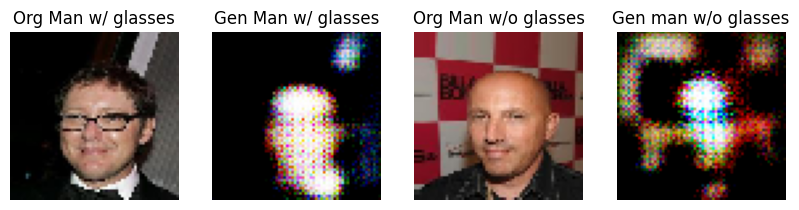

Epochs: 100%|██████████| 1/1 [31:24<00:00, 1884.70s/it]


In [25]:
#load image data
dataset = load_real_samples ('/content/celeb.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B,g_model_BtoA,image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A,g_model_AtoB,image_shape)
train(dataset,d_model_A,d_model_B, g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , epochs=1, chunk=5)